In [3]:
import pandas as pd
import numpy as np

In [4]:
from data_preparation import *


In [77]:
sampling_distance_x = 1
sampling_distance_y = 12
length = 10 # starting with 0.1m
whole_map = pd.read_csv('WholeMap_Rounds_40_to_17.csv')
map = stack_map(whole_map) # create a stacked map dataframe with columns x, y, z
map = cut_map_len(map,0,length) # cut the map to the length of the map
data_i, data_o = resample(map, sampling_distance_x, sampling_distance_y) # resample the map


In [50]:
x = map.x
y = map.y
#x = map['x'].unique()#/data_i.x.max()
#y = map['y'].unique()#/data_i.y.max()

In [51]:
x = (x-min(x))/(max(x)-min(x))
y = (y-min(y))/(max(y)-min(y))


In [52]:
N = x.shape[0]

In [53]:
num_basis = [10**2,19**2,37**2]
type(num_basis[2])

int

In [57]:

knots_1dx = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
knots_1dy = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
basis_size = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_x, knots_y = np.meshgrid(knots_1dx[res],knots_1dy[res])
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(np.vstack((y,x)).T-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + basis_size] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + basis_size] = 0
    basis_size = basis_size + num_basis[res]

In [59]:
phi = pd.DataFrame(phi)
phi.head()

,0,1,2,3,4,5,6,7,8,9,...,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829
0,1.000000,0.175560,0.000029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.991087,0.174036,0.000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.965011,0.169537,0.000026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.923524,0.162276,0.000023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.869083,0.152590,0.000018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
phi.to_csv('phi.csv')

In [115]:
def deep_model(model, X_train, y_train, X_valid, y_valid, data_type):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    if data_type == 'continuous':
        model.compile(optimizer='adam'
                      , loss='mse'
                      , metrics=['mse','mae'])
    if data_type == 'discrete':
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return model, history

In [116]:
##### idx for train/val split


print(f'max phi index : {phi.index.max()}')
print(f'max known points index : {data_i.index.max()}')
train_idx = [data_i.index[data_i.index < phi.index.max()]]
val_idx = [data_o.index[data_o.index < phi.index.max()]]
train_idx=train_idx[0]
val_idx = val_idx[0]


max phi index : 15599
max known points index : 15729


In [117]:
x_train = phi.iloc[train_idx].to_numpy()
y_train = data_i.z.loc[train_idx].to_numpy()
x_val = phi.iloc[val_idx].to_numpy()
y_val = data_o.z.loc[val_idx].to_numpy()

In [118]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

In [119]:
# DeepKriging model for continuous data
p = phi.shape[1]
model = Sequential()
model.add(Dense(100, input_dim = p,  kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))


In [142]:
NB_START_EPOCHS = 2000
BATCH_SIZE = 100

In [143]:
model, history = deep_model(model, x_train, y_train, x_val, y_val, 'continuous')

Epoch 1/2000
12/12 [==============================] - 2s 32ms/step - loss: 779.4952 - mse: 779.4952 - mae: 27.8080 - val_loss: 772.0003 - val_mse: 772.0003 - val_mae: 27.5943
Epoch 2/2000
12/12 [==============================] - 0s 14ms/step - loss: 765.9641 - mse: 765.9641 - mae: 27.5809 - val_loss: 754.6411 - val_mse: 754.6411 - val_mae: 27.2818
Epoch 3/2000
12/12 [==============================] - 0s 15ms/step - loss: 750.4754 - mse: 750.4754 - mae: 27.3160 - val_loss: 736.4106 - val_mse: 736.4106 - val_mae: 26.9493
Epoch 4/2000
12/12 [==============================] - 0s 12ms/step - loss: 733.7063 - mse: 733.7063 - mae: 27.0057 - val_loss: 714.4605 - val_mse: 714.4605 - val_mae: 26.5404
Epoch 5/2000
12/12 [==============================] - 0s 11ms/step - loss: 714.0635 - mse: 714.0635 - mae: 26.6451 - val_loss: 690.5341 - val_mse: 690.5341 - val_mae: 26.0892
Epoch 6/2000
12/12 [==============================] - 0s 24ms/step - loss: 692.1348 - mse: 692.1348 - mae: 26.2297 - val_loss

In [144]:
pd.DataFrame(history.history)[['loss','val_loss']]

,loss,val_loss
0,779.495239,772.000305
1,765.964050,754.641113
2,750.475403,736.410645
3,733.706299,714.460510
4,714.063477,690.534119
...,...,...
1995,0.518038,0.744945
1996,0.485690,0.661218
1997,0.398199,0.796226
1998,0.449889,0.624981


In [145]:
prediction = model.predict(x_val)

41/41 [==============================] - 0s 2ms/step


In [146]:
prediction = pd.DataFrame(prediction)

In [147]:
prediction.index = val_idx

In [148]:
pred_stacked = pd.merge(data_o[['x','y']], prediction,how='inner', left_index=True, right_index=True)
pred_stacked.columns = ['x','y','z']

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

In [150]:
vmin = np.min([pred_stacked.z.min(),data_o.z.min()])
vmax = np.max([pred_stacked.z.max(),data_o.z.max()])

Text(0.5, 1.0, 'validation data')

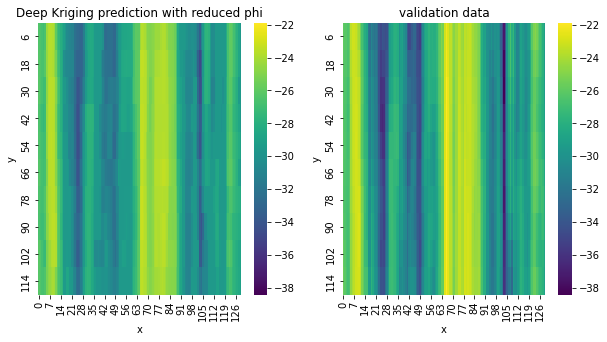

In [151]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot2grid((1,2), (0, 0))
ax2 = plt.subplot2grid((1,2), (0, 1))

sns.heatmap(ax=ax1,data=pred_stacked.pivot_table(index='y',columns='x',values='z'),vmin=vmin,vmax=vmax,cmap='viridis')
sns.heatmap(ax=ax2,data=data_o.loc[val_idx].pivot_table(index='y',columns='x',values='z'),vmin=vmin,vmax=vmax,cmap='viridis')
ax1.set_title('Deep Kriging prediction with reduced phi')
ax2.set_title('validation data')

In [152]:
mse_phi = np.mean((pred_stacked.z - data_o.z.loc[val_idx])**2)

In [153]:
mse_phi

0.7550707268173498

In [160]:
## Remove the all-zero columns
phi = phi.to_numpy()
idx_zero = np.array([], dtype=int)
for i in range(phi.shape[1]):
    if sum(phi[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

In [161]:
phi_reduce = np.delete(phi,idx_zero,1)
print(phi.shape)
print(phi_reduce.shape)

(15600, 1830)
(15600, 1830)
